In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

%load_ext autoreload
%autoreload 2

In [3]:
from NER_ETL import EntityETL

In [4]:
from NER_ETL import load_and_split_data

In [5]:
# load_and_split_data('clean_data/clean_data.csv', 0.6, 0.2, 0.2)

In [6]:
ner = EntityETL('glove/glove.6B.50d.txt', 50)

In [7]:
ner.load_train_vocab_nn('clean_data/clean_data.csv')

In [8]:
ner.vocab_size

8768

In [9]:
ner.ne_tag_map

{'UNK_NE': 1,
 'PAD': 0,
 'B-geo': 2,
 'I-gpe': 3,
 'B-per': 4,
 'I-tim': 5,
 'I-eve': 6,
 'B-eve': 7,
 'B-gpe': 8,
 'I-org': 9,
 'B-org': 10,
 'I-per': 11,
 'I-nat': 12,
 'B-tim': 13,
 'B-art': 14,
 'O': 15,
 'I-art': 16,
 'I-geo': 17,
 'B-nat': 18}

In [10]:
train_sent, train_labels = ner.load_input_data('clean_data/TRAIN_clean_data.csv')

In [11]:
train_sent[500]

['Some',
 'human',
 'rights',
 'groups',
 'rejected',
 'the',
 'changes',
 'for',
 'not',
 'going',
 'far',
 'enough',
 ',',
 'noting',
 'there',
 'is',
 'still',
 'no',
 'option',
 'for',
 'appeal',
 'to',
 'an',
 'independent',
 'court',
 '.']

In [12]:
ner.load_embed_vects(embedding_dim=50)

In [13]:
ner.embedding_weights_matrix.shape

(400004, 50)

In [14]:
ner.vocab['UNK']

1

In [16]:
nn_train_sent,nn_train_labels = ner.prep_input_for_nn()

In [18]:
ner.batch_starting_point

0

In [19]:
ner.embed_dict['PAD']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
ner.embed_dict['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [21]:
ner.embedding_weights_matrix[2]

array([ 4.18000013e-01,  2.49679998e-01, -4.12420005e-01,  1.21699996e-01,
        3.45270008e-01, -4.44569997e-02, -4.96879995e-01, -1.78619996e-01,
       -6.60229998e-04, -6.56599998e-01,  2.78430015e-01, -1.47670001e-01,
       -5.56770027e-01,  1.46579996e-01, -9.50950012e-03,  1.16579998e-02,
        1.02040000e-01, -1.27920002e-01, -8.44299972e-01, -1.21809997e-01,
       -1.68009996e-02, -3.32789987e-01, -1.55200005e-01, -2.31309995e-01,
       -1.91809997e-01, -1.88230002e+00, -7.67459989e-01,  9.90509987e-02,
       -4.21249986e-01, -1.95260003e-01,  4.00710011e+00, -1.85939997e-01,
       -5.22870004e-01, -3.16810012e-01,  5.92130003e-04,  7.44489999e-03,
        1.77780002e-01, -1.58969998e-01,  1.20409997e-02, -5.42230010e-02,
       -2.98709989e-01, -1.57490000e-01, -3.47579986e-01, -4.56370004e-02,
       -4.42510009e-01,  1.87849998e-01,  2.78489990e-03, -1.84110001e-01,
       -1.15139998e-01, -7.85809994e-01])

In [22]:
ner.embedding_weights_matrix.shape[0]

400004

In [23]:
ner.vocab['PAD']

0

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim, number_of_tags,
                 use_pretrained_embeddings = False, embedding_matrix = None, trainable=False):
        
        super(Net, self).__init__()

        #maps each token to an embedding_dim vector
        if use_pretrained_embeddings:
            self.embedding = nn.Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1], padding_idx=0)
            self.embedding.load_state_dict({'weight': torch.tensor(embedding_matrix)})
            if trainable == False:
                self.embedding.weight.requires_grad = False
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #the LSTM takens embedded sentence
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim, batch_first=True)

        #fc layer transforms the output to give the final output layer
        self.fc = nn.Linear(lstm_hidden_dim, number_of_tags)
        
        
    
#     def create_emb_layer(weights_matrix, non_trainable=False):
#         num_embeddings, embedding_dim = weights_matrix.shape
#         emb_layer = nn.Embedding.from_pretrained(weights_matrix, padding_idx=0)
#         emb_layer.load_state_dict({'weight': weights_matrix})
#         if non_trainable:
#             emb_layer.weight.requires_grad = False

#         return emb_layer, num_embeddings, embedding_dim
    
    
    def forward(self, s):
        #apply the embedding layer that maps each token to its embedding
        s = self.embedding(s)   # dim: batch_size x batch_max_len x embedding_dim

        #run the LSTM along the sentences of length batch_max_len
        s, _ = self.lstm(s)     # dim: batch_size x batch_max_len x lstm_hidden_dim                

        #reshape the Variable so that each row contains one token
        s = s.reshape(-1, s.shape[2])  # dim: batch_size*batch_max_len x lstm_hidden_dim

        #apply the fully connected layer and obtain the output for each token
        s = self.fc(s)          # dim: batch_size*batch_max_len x num_tags

        return F.log_softmax(s, dim=1)   # dim: batch_size*b

    def loss_fn( outputs, labels):
        #reshape labels to give a flat vector of length batch_size*seq_len
        labels = labels.view(-1)  

        #mask out 'PAD' tokens
        mask = (labels >= 1).float()

        num_tokens = int(torch.sum(mask))

        #pick the values corresponding to labels and multiply by mask

        #NOT SURE I UNDERSTAND THIS NEXT LINE, I"ll need to break it down
        outputs = outputs[range(outputs.shape[0]), labels]*mask

        #cross entropy loss for all non 'PAD' tokens
        return -torch.sum(outputs)/num_tokens
    
    
    def BCE_with_Logits_loss_fn(outputs, labels, criterion, weights):
        #reshape labels to flat vectors
        labels = labels.view(-1)
        
        #mask PAD tokens
        mask = (labels>=1).float()
        
        num_tokens = int(torch.sum(mask))
        
        outputs = outputs[range(outputs.shape[0]), labels] * mask
        
        labels = labels.type_as(outputs)
        
        loss = criterion(outputs, labels)
        
        loss = (loss*weights).mean()
        return loss
        
        
        

def myCrossEntropyLoss(outputs, labels):
    batch_size = outputs.size()[0]            # batch_size
    outputs = F.log_softmax(outputs, dim=1)   # compute the log of softmax values
    outputs = outputs[range(batch_size), labels] # pick the values corresponding to the labels
    return -torch.sum(outputs)/num_examples

def accuracy(out, labels):
    labels = labels.ravel()

    mask = (labels >= 0)

    outputs = np.argmax(out, axis=1)


    return np.sum(outputs==labels)/float(labels.size)




In [25]:
baseline_model = Net(ner.vocab_size, 50, 20, len(ner.ne_tag_map), True, ner.embedding_weights_matrix, False)

In [27]:
# optimizer = torch.optim.SGD(baseline_model.parameters(), lr = 0.01, momentum=0.9)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr = 0.0001)


In [28]:
ner.batch_starting_point = 0
train_iterator = ner.nn_batch_generator(nn_train_sent, nn_train_labels)

loss_over_step = []
acc_over_step = []


for i in range(1000):

    batch_sentences, batch_ne_labels = next(train_iterator)
    
#     batch_sentences = batch_sentences.contiguous()
#     batch_ne_labels = batch_ne_labels.contiguous()
    
    output_batch = baseline_model(batch_sentences)
    
    loss = Net.loss_fn(output_batch, batch_ne_labels)
    if i%100 == 0:
        print(i, "Current loss: --------- ", loss)
    
    loss_over_step.append(loss)

    

    
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients of all variables wrt loss
    optimizer.step()       # perform updates using calculated gradients
    
    
    # extract data from torch Variable, move to cpu, convert to numpy arrays
    output_batch = output_batch.data.cpu().numpy()
    batch_ne_labels = batch_ne_labels.data.cpu().numpy()
    acc = accuracy(output_batch, batch_ne_labels)
    if i%100 == 0:
        print("    Accuracy is ---------- ", acc)
        
        
    acc_over_step.append(acc)
    

0 Current loss: ---------  tensor(2.9061, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.002
100 Current loss: ---------  tensor(2.7480, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.198
200 Current loss: ---------  tensor(2.3908, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.4935
300 Current loss: ---------  tensor(1.7785, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5035
400 Current loss: ---------  tensor(1.3413, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.504
500 Current loss: ---------  tensor(1.0850, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
600 Current loss: ---------  tensor(0.9521, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
700 Current loss: ---------  tensor(0.8808, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
800 Current loss: ---------  tensor(0.8376, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
900 Current loss: ---------  tensor(0.8085, grad_fn=<DivBackward0>)
    Accura

No handles with labels found to put in legend.


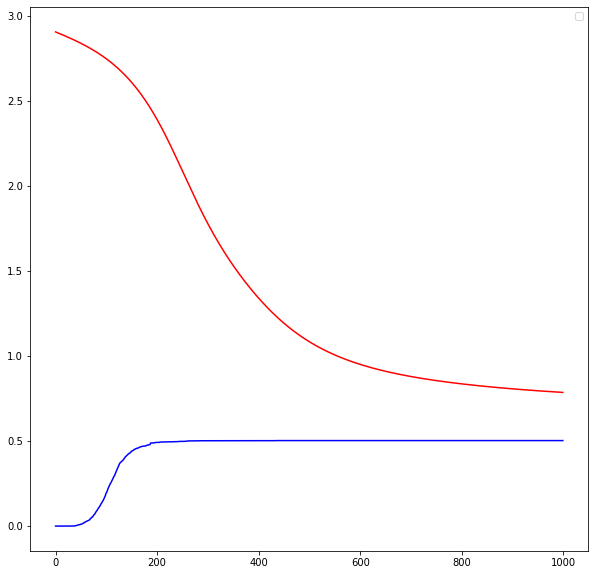

In [29]:
plt.figure(figsize=(10,10))
plt.plot( loss_over_step, c='red')
plt.plot( acc_over_step, c='blue')
plt.show()

As we can see, our model very, very quickly plateaus after a short number of steps. The model was trained with pretrained embeddings from GloVe, of dimension 50. 

### Performing a quick sanity check

In [30]:
ner.ne_tag_map

{'UNK_NE': 1,
 'PAD': 0,
 'B-geo': 2,
 'I-gpe': 3,
 'B-per': 4,
 'I-tim': 5,
 'I-eve': 6,
 'B-eve': 7,
 'B-gpe': 8,
 'I-org': 9,
 'B-org': 10,
 'I-per': 11,
 'I-nat': 12,
 'B-tim': 13,
 'B-art': 14,
 'O': 15,
 'I-art': 16,
 'I-geo': 17,
 'B-nat': 18}

In [43]:
for i in (np.argmax(output_batch, axis=1)):
    print(i)

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

In [32]:
batch_ne_labels[0]

array([15, 15, 15, 15, 15, 15,  2, 15, 15, 15, 15, 15,  2, 15, 15, 15, 15,
       15,  8, 15, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

#### Performance on validation data

In [33]:
valid_sent, valid_labels = ner.load_input_data('clean_data/VALID_clean_data.csv')
valid_sent, valid_labels = ner.prep_input_for_nn(valid_sent, valid_labels)
valid_iterator = ner.nn_batch_generator(valid_sent, valid_labels,)

In [35]:
ner.batch_starting_point = 0
loss_over_step = []
acc_over_step = []


for i in range(100):
    
    batch_sentences, batch_ne_labels = next(valid_iterator)
    
    output_batch = baseline_model(batch_sentences)
    
    loss = Net.loss_fn(output_batch, batch_ne_labels)
    loss_over_step.append(loss)
    # extract data from torch Variable, move to cpu, convert to numpy arrays
    output_batch = output_batch.data.cpu().numpy()
    batch_ne_labels = batch_ne_labels.data.cpu().numpy()
    
    acc = accuracy(output_batch, batch_ne_labels)
    acc_over_step.append(acc)
    


In [37]:
plt.figure(figsize=(10,10))
sns.lineplot(data=loss_over_step, )
sns.lineplot(data=acc_over_step, )
plt.show()

TypeError: len() of a 0-d tensor

<Figure size 720x720 with 0 Axes>

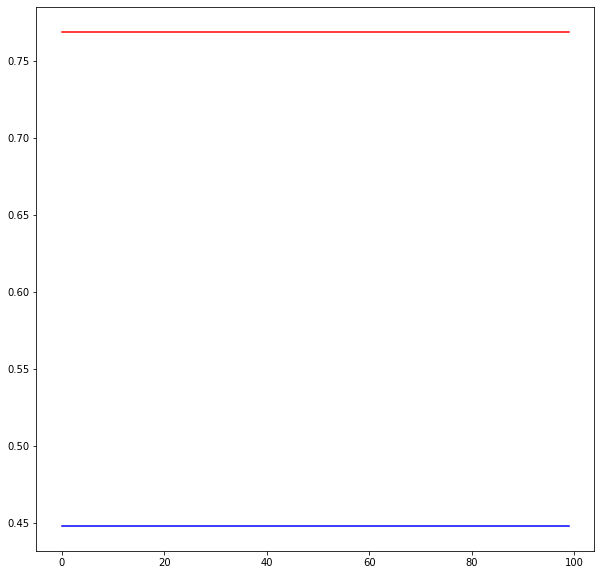

In [39]:
plt.figure(figsize=(10,10))
plt.plot( loss_over_step, c='red')
plt.plot( acc_over_step, c='blue')
plt.show()

## Second model

This time we'll be setting the embeddings to be trainable. 

In [44]:
baseline_model_2 = Net(ner.vocab_size, 50, 20, len(ner.ne_tag_map), True, ner.embedding_weights_matrix, True)

In [46]:
# optimizer = torch.optim.SGD(baseline_model.parameters(), lr = 0.01, momentum=0.9)
optimizer = torch.optim.Adam(baseline_model_2.parameters(), lr = 0.0001)


In [47]:
ner.batch_starting_point = 0
train_iterator = ner.nn_batch_generator(nn_train_sent, nn_train_labels)

loss_over_step = []
acc_over_step = []


for i in range(1000):

    batch_sentences, batch_ne_labels = next(train_iterator)
    
#     batch_sentences = batch_sentences.contiguous()
#     batch_ne_labels = batch_ne_labels.contiguous()
    
    output_batch = baseline_model_2(batch_sentences)
    
    loss = Net.loss_fn(output_batch, batch_ne_labels)
    if i%100 == 0:
        print(i, "Current loss: --------- ", loss)
    
    loss_over_step.append(loss)

    

    
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients of all variables wrt loss
    optimizer.step()       # perform updates using calculated gradients
    
    
    # extract data from torch Variable, move to cpu, convert to numpy arrays
    output_batch = output_batch.data.cpu().numpy()
    batch_ne_labels = batch_ne_labels.data.cpu().numpy()
    acc = accuracy(output_batch, batch_ne_labels)
    if i%100 == 0:
        print("    Accuracy is ---------- ", acc)
        
        
    acc_over_step.append(acc)
    

0 Current loss: ---------  tensor(3.2062, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.0055
100 Current loss: ---------  tensor(3.0294, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.0075
200 Current loss: ---------  tensor(2.8122, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.0915
300 Current loss: ---------  tensor(2.4643, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.4655
400 Current loss: ---------  tensor(1.9948, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.4975
500 Current loss: ---------  tensor(1.4904, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5025
600 Current loss: ---------  tensor(1.1427, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
700 Current loss: ---------  tensor(0.9602, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
800 Current loss: ---------  tensor(0.8635, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
900 Current loss: ---------  tensor(0.8067, grad_fn=<DivBackward0>)
    Acc

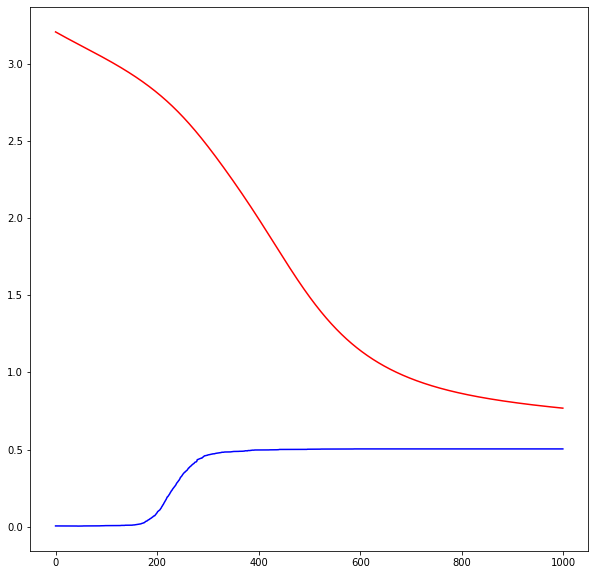

In [48]:
plt.figure(figsize=(10,10))
plt.plot( loss_over_step, c='red')
plt.plot( acc_over_step, c='blue')
plt.show()

## Third baseline

In [51]:
baseline_model_3 = Net(ner.vocab_size, 50, 50, len(ner.ne_tag_map), True, ner.embedding_weights_matrix, True)

In [52]:
# optimizer = torch.optim.SGD(baseline_model.parameters(), lr = 0.01, momentum=0.9)
optimizer = torch.optim.Adam(baseline_model_3.parameters(), lr = 0.0001)


0 Current loss: ---------  tensor(2.8556, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.037
100 Current loss: ---------  tensor(2.4891, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5
200 Current loss: ---------  tensor(1.1184, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
300 Current loss: ---------  tensor(0.8772, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
400 Current loss: ---------  tensor(0.8101, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
500 Current loss: ---------  tensor(0.7725, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
600 Current loss: ---------  tensor(0.7458, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
700 Current loss: ---------  tensor(0.7239, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
800 Current loss: ---------  tensor(0.7032, grad_fn=<DivBackward0>)
    Accuracy is ----------  0.5045
900 Current loss: ---------  tensor(0.6799, grad_fn=<DivBackward0>)
    Accurac

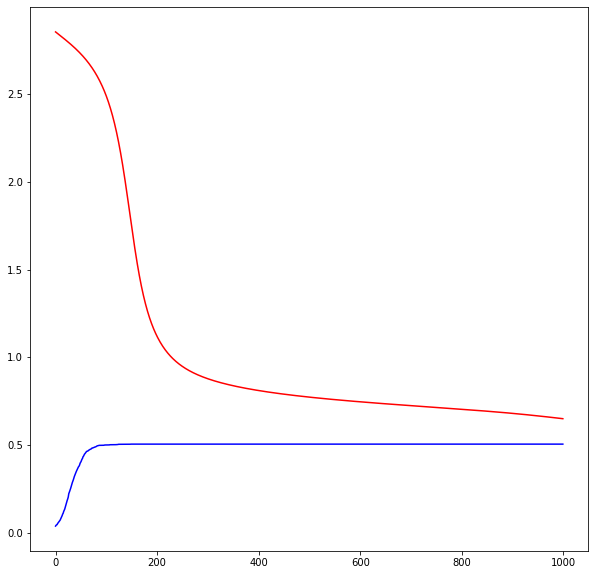

In [53]:
ner.batch_starting_point = 0
train_iterator = ner.nn_batch_generator(nn_train_sent, nn_train_labels)

loss_over_step = []
acc_over_step = []


for i in range(1000):

    batch_sentences, batch_ne_labels = next(train_iterator)
    
#     batch_sentences = batch_sentences.contiguous()
#     batch_ne_labels = batch_ne_labels.contiguous()
    
    output_batch = baseline_model_3(batch_sentences)
    
    loss = Net.loss_fn(output_batch, batch_ne_labels)
    if i%100 == 0:
        print(i, "Current loss: --------- ", loss)
    
    loss_over_step.append(loss)

    

    
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients of all variables wrt loss
    optimizer.step()       # perform updates using calculated gradients
    
    
    # extract data from torch Variable, move to cpu, convert to numpy arrays
    output_batch = output_batch.data.cpu().numpy()
    batch_ne_labels = batch_ne_labels.data.cpu().numpy()
    acc = accuracy(output_batch, batch_ne_labels)
    if i%100 == 0:
        print("    Accuracy is ---------- ", acc)
        
        
    acc_over_step.append(acc)

    
plt.figure(figsize=(10,10))
plt.plot( loss_over_step, c='red')
plt.plot( acc_over_step, c='blue')
plt.show()

## Fourth baseline

In [98]:
#extracting and creating inverse freq weights for the target labels; this will be refactored more neatly into the NER class
ner_labels = pd.read_csv('clean_data/TRAIN_clean_data.csv', index_col=0)
ner_labels = ner_labels.groupby(by='Tag').count()
# freq_tags = ner_labels.value_counts()

In [99]:
ner.ne_tag_map

{'UNK_NE': 1,
 'PAD': 0,
 'B-geo': 2,
 'I-gpe': 3,
 'B-per': 4,
 'I-tim': 5,
 'I-eve': 6,
 'B-eve': 7,
 'B-gpe': 8,
 'I-org': 9,
 'B-org': 10,
 'I-per': 11,
 'I-nat': 12,
 'B-tim': 13,
 'B-art': 14,
 'O': 15,
 'I-art': 16,
 'I-geo': 17,
 'B-nat': 18}

In [100]:
ner_labels.head()

,Sentence #,Word,POS
Tag,,,
B-art,46,46,46
B-eve,29,29,29
B-geo,1228,1228,1228
B-gpe,849,849,849
B-nat,17,17,17


In [101]:
ner_labels['inv_freq'] = 1/ner_labels.Word
ner_labels

,Sentence #,Word,POS,inv_freq
Tag,,,,
B-art,46,46,46,0.021739
B-eve,29,29,29,0.034483
B-geo,1228,1228,1228,0.000814
B-gpe,849,849,849,0.001178
B-nat,17,17,17,0.058824
B-org,837,837,837,0.001195
B-per,663,663,663,0.001508
B-tim,730,730,730,0.001370
I-art,25,25,25,0.040000


In [75]:
inv_freq_weights = []
    
for tag in ner.ne_tag_map.keys():
    if tag=='PAD':
        inv_freq_weights.append(0.0)
        continue
    if tag=='UNK_NE':
        inv_freq_weights.append(0.0) # for unknown tags, we will in future have to devise a better system
        continue 
    total_freq=freq_tags[tag]
    inv_freq = 1/total_freq
    inv_freq_weights.append(inv_freq)
    
    
inv_freq_weights = torch.tensor(inv_freq_weights)
inv_freq_weights

tensor([0.0000e+00, 0.0000e+00, 8.1433e-04, 3.5714e-02, 1.5083e-03, 4.9261e-03,
        4.7619e-02, 3.4483e-02, 1.1779e-03, 1.7153e-03, 1.1947e-03, 1.2937e-03,
        1.1111e-01, 1.3699e-03, 2.1739e-02, 2.7735e-05, 4.0000e-02, 4.0650e-03,
        5.8824e-02], dtype=torch.float64)

In [115]:
baseline_model_4 = Net(ner.vocab_size, 50, 50, len(ner.ne_tag_map), False,)

In [116]:
# optimizer = torch.optim.SGD(baseline_model.parameters(), lr = 0.01, momentum=0.9)
optimizer = torch.optim.Adam(baseline_model_4.parameters(), lr = 0.0001)
bce_criterion = nn.BCEWithLogitsLoss(reduction='none')


In [117]:
ner.batch_starting_point = 0
train_iterator = ner.nn_batch_generator(nn_train_sent, nn_train_labels)

loss_over_step = []
acc_over_step = []


for i in range(1000):

    batch_sentences, batch_ne_labels = next(train_iterator)
    
#     batch_sentences = batch_sentences.contiguous()
#     batch_ne_labels = batch_ne_labels.contiguous()
    
    output_batch = baseline_model_4(batch_sentences)
    
#     loss = Net.loss_fn(output_batch, batch_ne_labels)
    
    loss = Net.BCE_with_Logits_loss_fn(output_batch, batch_ne_labels, bce_criterion, inv_freq_weights)
    
    if i%100 == 0:
        print(i, "Current loss: --------- ", loss)
    
    loss_over_step.append(loss)

    

    
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients of all variables wrt loss
    optimizer.step()       # perform updates using calculated gradients
    
    
    # extract data from torch Variable, move to cpu, convert to numpy arrays
    output_batch = output_batch.data.cpu().numpy()
    batch_ne_labels = batch_ne_labels.data.cpu().numpy()
    acc = accuracy(output_batch, batch_ne_labels)
    if i%100 == 0:
        print("    Accuracy is ---------- ", acc)
        
        
    acc_over_step.append(acc)

    
plt.figure(figsize=(10,10))
plt.plot( loss_over_step, c='red')
plt.plot( acc_over_step, c='blue')
plt.show()

RuntimeError: The size of tensor a (2000) must match the size of tensor b (19) at non-singleton dimension 0